In [1]:
import pandas as pd
import os

# Specify the directory containing the pickle files
directory = '../ressources/final_experiments/result_aggregation_exp'

# Initialize a list or dictionary to hold the DataFrames
dataframes = {}

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pickle'):  # Check for pickle files
        file_path = os.path.join(directory, filename)  # Create full file path
        df = pd.read_pickle(file_path)  # Load the DataFrame from the pickle file
        dataframes[filename] = df  # Store the DataFrame in the dictionary

dataframes.keys()


dict_keys(['llm_evaluated_only_white.pickle', 'llm_evaluated_only_black.pickle', 'llm_evaluated_control_mixed_samesize.pickle'])

In [2]:
list(dataframes.values())[0].head(3)

,level_0,index,description,configuration,parameters,argos,behavior_tree,scores,avg_score,type,lightstype,arenatype,robotstype,target_color,llm_scores,llm_behavior_tree,llm_avg_score
0,1,5,The area is a rectangle with dimensions 6.56 x...,"<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=RectangularArena(le...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 4 --n0 0 --nchild0 2 --...,"[0.333333, 0.0833333, 0.166667, 0.0833333, 0.0...",0.150000,Aggregation,UniformLights,RectangularArena,CenteredSwarm,white,"[0.666667, 0.666667, 0.416667, 0.583333, 0.666...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 -...,0.633333
1,5,20,"With a length of 6.99 meters, width of 7.46 me...","<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=RectangularArena(le...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 --...,"[0.888889, 0.888889, 0.888889, 0.777778, 0.777...",0.855556,Aggregation,TargetLights,RectangularArena,CenteredSwarm,white,"[0.444444, 0.555556, 0.444444, 0.444444, 0.666...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 -...,0.544444
2,6,28,"In this setting, a circular arena with a radiu...","<?xml version=""1.00"" ?>\n<config>\n <swarm-el...",MissionParams(arena_params=CircularArena(radiu...,"<?xml version=""1.00"" ?>\n<argos-configuration>...",--nroot 3 --nchildroot 4 --n0 0 --nchild0 2 --...,"[0.153846, 0.461538, 0.230769, 0.384615, 0.538...",0.376923,Aggregation,TargetLights,CircularArena,CenteredSwarm,white,"[0.769231, 0.538462, 0.615385, 0.615385, 0.615...",--nroot 3 --nchildroot 3 --n0 0 --nchild0 2 -...,0.638462


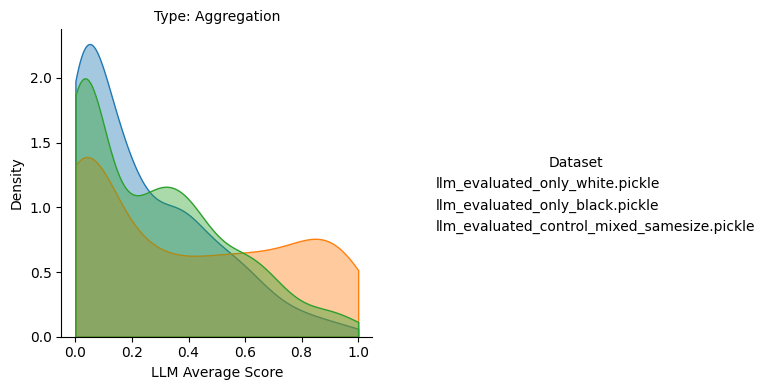

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine data from all three dataframes into one
df_list = []
for name, df in dataframes.items():
    temp_df = df[['type', 'llm_avg_score']].copy()
    temp_df['Dataset'] = name  # Add a column to indicate the dataset
    df_list.append(temp_df)

df_combined = pd.concat(df_list, ignore_index=True)

# Define clipping for specific types
clip_limits = {
    "Foraging": (0, None),       # 0 to ∞
    "Aggregation": (0, 1),       # 0 to 1
    "Distribution": (None, 0),   # -∞ to 0
    "Connection": (None, 0)      # -∞ to 0
}

# Create the FacetGrid
g = sns.FacetGrid(df_combined, col='type', hue='Dataset', height=4, aspect=1, sharex=False, sharey=False)

# Apply kdeplot to each facet with appropriate clipping
for type_name, ax in zip(g.col_names, g.axes.flat):
    subset = df_combined[df_combined["type"] == type_name]  # Select relevant data
    clip_range = clip_limits.get(type_name, (0, None))  # Get appropriate clipping limits
    
    # Plot all datasets in the same facet
    for dataset in subset["Dataset"].unique():
        sns.kdeplot(data=subset[subset["Dataset"] == dataset], x='llm_avg_score', 
                    fill=True, alpha=0.4, clip=clip_range, ax=ax, label=dataset)

g.set_titles(col_template='Type: {col_name}')
g.set_axis_labels('LLM Average Score', 'Density')

# Add a legend
g.add_legend(title='Dataset')

# Show the plot
g.tight_layout()
plt.show()


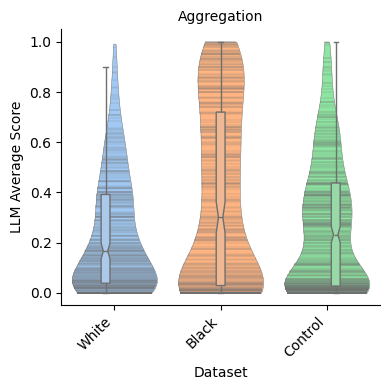

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create the FacetGrid with violin plots
g = sns.FacetGrid(df_combined, col='type', height=4, aspect=1, sharex=True, sharey=False)

# Violin plot with one side and density normalization
g.map_dataframe(sns.violinplot, x='Dataset', y='llm_avg_score', hue='Dataset', 
                split=False, inner='stick', density_norm='area', 
                palette="pastel", cut=0, dodge=False, native_scale=True, legend="auto", 
                saturation=1.0, linewidth=0.33)

# Overlay notched boxplots
g.map_dataframe(sns.boxplot, x='Dataset', y='llm_avg_score', hue='Dataset', 
                dodge=True, width=0.25, palette="pastel", 
                fliersize=0, notch=True, linewidth=1.0)

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Dataset', 'LLM Average Score')

# Rename x-axis labels to shorter names
label_mapping = {
'llm_evaluated_only_white.pickle': "White", 
'llm_evaluated_only_black.pickle': "Black",
'llm_evaluated_control_mixed_samesize.pickle': "Control"
}

# Manually replace the Dataset values in the plot
for ax in g.axes.flat:
    # Get the current x-ticks
    current_ticks = ax.get_xticks()
    
    # Explicitly set the new tick labels and positions
    new_labels = [label_mapping.get(df_combined['Dataset'].unique()[int(tick)], 'Unknown') for tick in current_ticks]
    ax.set_xticks(current_ticks)  # Ensure the ticks are set first
    ax.set_xticklabels(new_labels, rotation=45, ha='right')

# Set log scale for the y-axis of the first facet (e.g., for the first facet in the first row)
#g.axes[0, 0].set_yscale('log')  # Set log scale for the y-axis of the first facet

# Show the plot
g.tight_layout()
plt.show()


In [5]:
# Calculate min, mean, and max of 'llm_avg_score' grouped by 'type' and 'Dataset'
summary_stats = df_combined.groupby(['type', 'Dataset'])['llm_avg_score'].agg(['min', 'mean', 'max']).reset_index()

# Pivot the table to have 'Dataset' on the rows and 'type' on the columns
pivot_table = summary_stats.pivot_table(index='Dataset', columns='type', values=['min', 'mean', 'max'])

# Display the pivot table
pivot_table



,max,mean,min
type,Aggregation,Aggregation,Aggregation
Dataset,,,
llm_evaluated_control_mixed_samesize.pickle,1.000000,0.274364,0.0
llm_evaluated_only_black.pickle,1.000000,0.388993,0.0
llm_evaluated_only_white.pickle,0.990909,0.240329,0.0


In [12]:
df_list = []
for name, df in dataframes.items():
    temp_df = df[['type','avg_score', 'llm_avg_score']].copy()
    temp_df['Dataset'] = name  # Add a column to indicate the dataset
    df_list.append(temp_df)

df_combined = pd.concat(df_list, ignore_index=True)
#df_combined

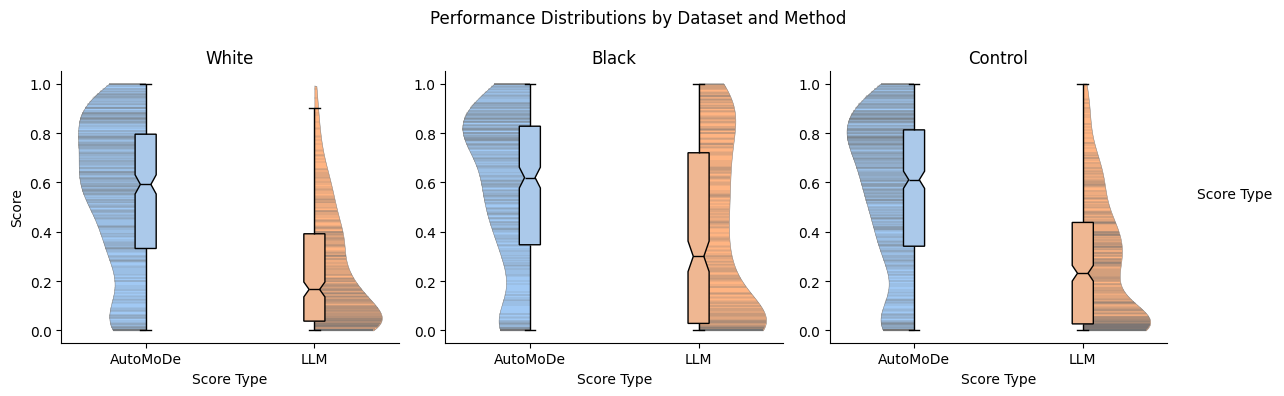

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure the data is in the correct format for the plot
# Melt the DataFrame to combine avg_score and llm_avg_score into a single column 'Score Type'
df_melted = df_combined.melt(id_vars=['Dataset'], 
                             value_vars=['avg_score', 'llm_avg_score'], 
                             var_name='Score Type', value_name='Score')

# Create the FacetGrid with violin plots, facet by 'Dataset'
g = sns.FacetGrid(df_melted, col='Dataset', height=4, aspect=1, sharex=True, sharey=False)
g.map_dataframe(sns.violinplot, x='Score Type', y='Score', hue='Score Type', 
                split=True, inner='stick', density_norm='area', 
                palette="pastel", cut=0, dodge=True, native_scale=True, legend="auto", 
                saturation=1.0, linewidth=0.33)

# Overlay notched boxplots for both score types
g.map_dataframe(sns.boxplot, x='Score Type', y='Score', hue='Score Type', 
                dodge=False, width=0.125, palette="pastel",
                fliersize=0, notch=True, linewidth=1.0, linecolor="black")

# Set titles and labels
g.set_titles(col_template='{col_name}')
g.set_axis_labels('Score Type', 'Score')

# Rename the x-tick labels to more meaningful names
label_mapping = {
    'avg_score': 'AutoMoDe',
    'llm_avg_score': 'LLM'
}

for ax in g.axes.flat:
    # Get the current tick positions
    ticks = ax.get_xticks()
    # Set the tick positions and the new labels
    ax.set_xticks(ticks)
    ax.set_xticklabels([label_mapping.get(label, label) for label in ['avg_score', 'llm_avg_score']])

# Manually rename the facet titles
facet_title_mapping = {
    'llm_evaluated_only_white.pickle': 'White',
    'llm_evaluated_only_black.pickle': 'Black',
    'llm_evaluated_control_mixed_samesize.pickle': 'Control',
    # Add more mappings for each dataset as necessary
}

for ax, dataset in zip(g.axes.flat, df_combined['Dataset'].unique()):
    ax.set_title(facet_title_mapping.get(dataset, dataset))

# Add a legend
g.add_legend(title='Score Type')

# Show the plot
g.figure.suptitle('Performance Distributions by Dataset and Method')
g.tight_layout()
plt.show()


In [ ]:
dataframes["llm_evaluated_only_white.pickle"].shape,dataframes["llm_evaluated_only_black.pickle"].shape,dataframes["llm_evaluated_control_mixed_samesize.pickle"].shape

((349, 17), (320, 17), (450, 16))

In [ ]:
import pandas as pd

# Create a pivot table to calculate min, max, mean, and median for each 'Dataset'
pivot_table = df_combined.pivot_table(
    values='avg_score',
    index='Dataset',
    aggfunc=['min', 'max', 'mean', 'median']
).reset_index()

# Rename the columns for clarity
pivot_table.columns = ['Dataset', 'Min avg_score', 'Max avg_score', 'Mean avg_score', 'Median avg_score']

# Display the pivot table
pivot_table


,Dataset,Min avg_score,Max avg_score,Mean avg_score,Median avg_score
0,llm_evaluated_control_mixed_samesize.pickle,0.0,1.0,0.559144,0.610428
1,llm_evaluated_only_black.pickle,0.0,1.0,0.567415,0.619222
2,llm_evaluated_only_white.pickle,0.0,1.0,0.551172,0.591666


In [ ]:
df_formal = pd.read_pickle('../ressources/final_experiments/result_formal_descriptions_exp/llm_evaluated.pickle')

In [ ]:
t = df_formal[df_formal.type == "Aggregation"].configuration.iloc[0]

In [ ]:
df_formal_agg = df_formal[df_formal.type == "Aggregation"]

In [ ]:
print(t)

<?xml version="1.00" ?>
<config>
  <swarm-elems>
    <entity quantity="15" max_trials="100">
      <e-puck id="epuck">
        <controller config="automode_bt"/>
      </e-puck>
    </entity>
  </swarm-elems>
  <env-elems>
    <light id="light_0" position="0.82,-0.74,0.00" orientation="360,0,0" color="yellow" intensity="6.13" medium="leds"/>
    <light id="light_1" position="-0.00,-1.11,0.00" orientation="360,0,0" color="yellow" intensity="7.93" medium="leds"/>
    <box id="wall_0" size="0.01,1.36,0.10" movable="false">
      <body position="1.76,0.64,0" orientation="20.00,0,0"/>
    </box>
    <box id="wall_1" size="0.01,1.36,0.10" movable="false">
      <body position="0.94,1.62,0" orientation="60.00,0,0"/>
    </box>
    <box id="wall_2" size="0.01,1.36,0.10" movable="false">
      <body position="-0.33,1.84,0" orientation="100.00,0,0"/>
    </box>
    <box id="wall_3" size="0.01,1.36,0.10" movable="false">
      <body position="-1.44,1.20,0" orientation="140.00,0,0"/>
    </box>
  

In [ ]:
import xml.etree.ElementTree as ET
df = df_formal_agg
# Function to extract target color from XML
def extract_target_color(xml_string):
    try:
        root = ET.fromstring(xml_string)
        target_color = root.find('.//objective-params').get('target-color')
        return target_color
    except Exception as e:
        return None  # Return None if parsing fails

# Apply the function to the 'configuration' column and create a new column 'agg_target'
df['agg_target'] = df['configuration'].apply(extract_target_color)

/tmp/ipykernel_377792/24231553.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['agg_target'] = df['configuration'].apply(extract_target_color)


In [ ]:
df_white = df[df.agg_target == "white"]
df_black = df[df.agg_target == "black"]

len_black = len(df_black['llm_avg_score'])
len_white = len(df_white['llm_avg_score'])

df_black.llm_avg_score, df_white.llm_avg_score

# Combine the two scores into a single DataFrame
# Use the minimum length to avoid ValueError
min_length = min(len_black, len_white)

combined_df = pd.DataFrame({
    'llm_avg_score_black': df_black['llm_avg_score'].values[:min_length],
    'llm_avg_score_white': df_white['llm_avg_score'].values[:min_length],
    'type': df_white['type'].values[:min_length]  # Assuming you want the type from df_white
})

combined_df


,llm_avg_score_black,llm_avg_score_white,type
0,0.693333,0.075000,Aggregation
1,0.760000,0.100000,Aggregation
2,0.068750,0.569231,Aggregation
3,0.455556,0.314285,Aggregation
4,0.433333,0.452632,Aggregation
5,0.500000,0.029412,Aggregation
6,0.428571,0.026087,Aggregation
7,0.050000,0.000000,Aggregation
8,0.080000,0.200000,Aggregation
9,0.480000,0.736364,Aggregation


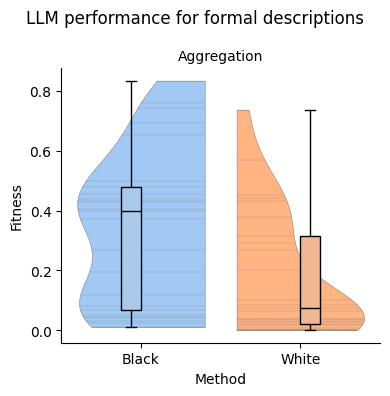

In [ ]:
def generate_violin_boxplot(df, id_var='type', value_vars=['avg_score', 'llm_avg_score'], 
                             score_labels={'avg_score': 'AutoMoDe', 'llm_avg_score': 'LLM'}, 
                             title='Performance Distributions by Mission and Method', notch=False):
    """
    Generate a violin and box plot for the given DataFrame.

    Parameters:
    - df: DataFrame containing the data to plot.
    - id_var: Column name to use as identifier variable (default is 'type').
    - value_vars: List of column names to melt (default is ['avg_score', 'llm_avg_score']).
    - score_labels: Dictionary to map score variable names to display labels.
    - title: Title of the plot.
    """
    # Melt the DataFrame
    df_melted = df.melt(id_vars=[id_var], value_vars=value_vars, 
                         var_name='Score Type', value_name='Score')

    # Create a FacetGrid with violin plots
    g = sns.FacetGrid(df_melted, col=id_var, height=4, aspect=1, sharex=True, sharey=False)
    g.map_dataframe(sns.violinplot, x='Score Type', y='Score', hue='Score Type', 
                    split=True, inner='stick', density_norm='area', 
                    palette="pastel", cut=0, dodge=False, native_scale=True, 
                    legend="auto", saturation=1.0, linewidth=0.33)

    # Overlay notched boxplots
    g.map_dataframe(sns.boxplot, x='Score Type', y='Score', hue='Score Type', 
                    dodge=True, width=0.25, palette="pastel", 
                    fliersize=0, notch=notch, linewidth=1.0, linecolor="black")

    # Set titles and labels
    g.set_titles(col_template='{col_name}')
    g.set_axis_labels('Method', 'Fitness')

    # Rename the x-tick labels
    for ax in g.axes.flat:
        # Get the current tick positions
        ticks = ax.get_xticks()
        # Set the new tick labels
        ax.set_xticks(ticks)
        ax.set_xticklabels([score_labels.get(label, label) for label in value_vars])

    # Add a title to the figure
    g.figure.suptitle(title)
    g.tight_layout()
    plt.show()

generate_violin_boxplot(combined_df, id_var='type', value_vars=['llm_avg_score_black',"llm_avg_score_white"], 
                             score_labels={'llm_avg_score_black': 'Black', 'llm_avg_score_white': 'White'}, 
                             title='LLM performance for formal descriptions')